In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.losses import Loss
import tensorflow as tf

class MaskLoss(Loss):
    def __init__(self, **kwargs):  # Add kwargs for config compatibility
        super(MaskLoss, self).__init__(**kwargs)


    def call(self, y_true, y_pred):
        # Extract the first two channels (actual ground truth)
        y_true_deformed = y_true[..., :2]  # Shape: [batch_size, height, width, 2]

        # Extract the third channel (mask)
        mask = y_true[..., 2]  # Shape: [batch_size, height, width]

        # Compute the ratio of foreground to background
        num_foreground = tf.reduce_sum(tf.cast(mask == 1, tf.float32))
        num_background = tf.reduce_sum(tf.cast(mask == 0, tf.float32))

        # Compute final_ratio, ensuring stability
        final_ratio = num_background / (num_foreground + 1e-6)
        final_ratio = tf.clip_by_value(final_ratio, 0.1, 10)  # Prevent extreme values

        # Compute squared error
        squared_error = tf.square(y_true_deformed - y_pred)  # Shape: [batch_size, height, width, 2]

        # Assign higher weight to masked region
        # weighted_mask = tf.where(mask == 1, final_ratio, 1.0)  # Shape: [batch_size, height, width]

        # Expand dimensions to match squared_error shape
        weighted_mask = tf.expand_dims(mask, axis=-1)  # Shape: [batch_size, height, width, 1]

        # Apply weighted loss
        weighted_error = weighted_mask * squared_error

        mask_sum = tf.reduce_sum(weighted_mask)
        num_of_pixels = tf.cast(128 * 128, tf.float32)
        
        mask_ratio = num_of_pixels / (mask_sum + 1e-6)

        weighted_error = weighted_error * mask_ratio

        mean_error = tf.reduce_mean(weighted_error)

        return mean_error
    
    def get_config(self):  # 🚀 Add this to fix the TypeError!
        base_config = super(MaskLoss, self).get_config()
        return base_config

    
class MAELoss(Loss):
    def __init__(self, **kwargs):
        super(MAELoss, self).__init__(**kwargs)


    def call(self, y_true, y_pred):
        return tf.reduce_mean(tf.abs(y_true[..., :2]  - y_pred))
    
    def get_config(self):  
        base_config = super(MAELoss, self).get_config()
        return base_config

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
from keras.layers import Input, concatenate, add, Multiply, Lambda
from keras.layers import Conv3D, MaxPooling3D, MaxPooling2D, UpSampling2D,UpSampling3D, Conv2D
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.models import Model
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, Add, Multiply, BatchNormalization, Activation
from tensorflow.keras.models import Model


class Conv_block(tf.keras.Model):
    def __init__(self,num_filters):
        super(Conv_block, self).__init__()
        self.conv1 = Conv2D(num_filters, 3, padding = 'same', kernel_initializer = 'he_normal')
        self.bn1 = BatchNormalization()
        self.act1 = Activation('relu')
        self.conv2 = Conv2D(num_filters, 3, padding = 'same', kernel_initializer = 'he_normal')
        self.bn2 = BatchNormalization()
        self.act2 = Activation('relu')
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        return x
    
    def get_config(self):
        config = super().get_config()
        config.update({'num_filters': self.num_filters})
        return config

class UpConv_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(UpConv_block, self).__init__()
        self.upconv = Conv2DTranspose(num_filters, 3, strides = 2, padding = 'same')
        self.bn = BatchNormalization()
        self.act = Activation('relu')

    def call(self, inputs):
        x = self.upconv(inputs)
        x = self.bn(x)
        x = self.act(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({'num_filters': self.num_filters})
        return config
class Max_pool(tf.keras.Model):
    def __init__(self):
        super(Max_pool, self).__init__()
        self.pool = MaxPooling2D(pool_size = (2,2))

    def call(self, inputs):
        x = self.pool(inputs)
        return x
    
    def get_config(self):
        config = super().get_config()
        return config


class Unet(tf.keras.Model):
    def __init__(self, trainable = True, dtype=None, **kwargs):
        super(Unet, self).__init__()
        self.conv_block1 = Conv_block(64)
        self.pool1 = Max_pool()
        self.conv_block2 = Conv_block(128)
        self.pool2 = Max_pool()
        self.conv_block3 = Conv_block(256)
        self.pool3 = Max_pool()
        self.conv_block4 = Conv_block(512)
        self.pool4 = Max_pool()

        # bottleneck
        self.conv_block5 = Conv_block(1024)

        self.upconv_block1 = UpConv_block(512)
        self.conv_block6 = Conv_block(512)
        self.upconv_block2 = UpConv_block(256)
        self.conv_block7 = Conv_block(256)
        self.upconv_block3 = UpConv_block(128)
        self.conv_block8 = Conv_block(128)
        self.upconv_block4 = UpConv_block(64)
        self.conv_block9 = Conv_block(64)

        self.output_def = Conv2D(2, 1, activation = 'linear')

    def call(self, inputs):
        moving, fixed = inputs
        inputs = concatenate([moving, fixed], axis = -1)

        conv1 = self.conv_block1(inputs)
        pool1 = self.pool1(conv1)
        conv2 = self.conv_block2(pool1)
        pool2 = self.pool2(conv2)
        conv3 = self.conv_block3(pool2)
        pool3 = self.pool3(conv3)
        conv4 = self.conv_block4(pool3)
        pool4 = self.pool4(conv4)

        # bottleneck
        conv5 = self.conv_block5(pool4)

        upconv1 = self.upconv_block1(conv5)
        concat1 = Concatenate()([conv4, upconv1])
        conv6 = self.conv_block6(concat1)
        upconv2 = self.upconv_block2(conv6)
        concat2 = Concatenate()([conv3, upconv2])
        conv7 = self.conv_block7(concat2)
        upconv3 = self.upconv_block3(conv7)
        concat3 = Concatenate()([conv2, upconv3])
        conv8 = self.conv_block8(concat3)
        upconv4 = self.upconv_block4(conv8)
        concat4 = Concatenate()([conv1, upconv4])
        conv9 = self.conv_block9(concat4)

        output = self.output_def(conv9)
        return output
    
    def get_config(self):
        config = super().get_config()
        return config
    
    

In [ ]:
# Define the path to the pre-trained model weights
weights_path = "/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/FrameWork/Models/Unet.keras"

# Load the pre-trained model using TensorFlow's load_model function
# Custom objects (MaskLoss, MAELoss, Unet) are passed to ensure compatibility with the custom layers and loss functions
model = tf.keras.models.load_model(weights_path, custom_objects={'MaskLoss': MaskLoss, 'MAELoss': MAELoss, 'Unet': Unet})

2025-04-25 15:46:09.600293: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-04-25 15:46:09.600312: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-25 15:46:09.600316: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-25 15:46:09.600517: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-25 15:46:09.600525: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
# Load two frames (frame1 and frame2) from the specified .npy files.
# These frames are likely slices of medical imaging data.
frame1 = np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Frames/patient059_frame09_slice_5_ACDC_#5_1.npy")
frame2 = np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Frames/patient059_frame09_slice_5_ACDC_#5_2.npy")

# Add an additional dimension to the frames to make them compatible with the model's input shape.
# The model expects a batch dimension, so the shape changes from (128, 128) to (1, 128, 128).
frame1 = tf.expand_dims(frame1, axis=0)
frame2 = tf.expand_dims(frame2, axis=0)

# Use the pre-trained model to predict the deformation field between the two frames.
# The model takes the two frames as input and outputs the predicted deformation field.
predicted = model.predict([frame1, frame2])

/Users/ahmed_ali/.pyenv/versions/3.11.6/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['moving_image', 'fixed_image']. Received: the structure of inputs=('*', '*')
  warnings.warn(
2025-04-25 15:46:12.451648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


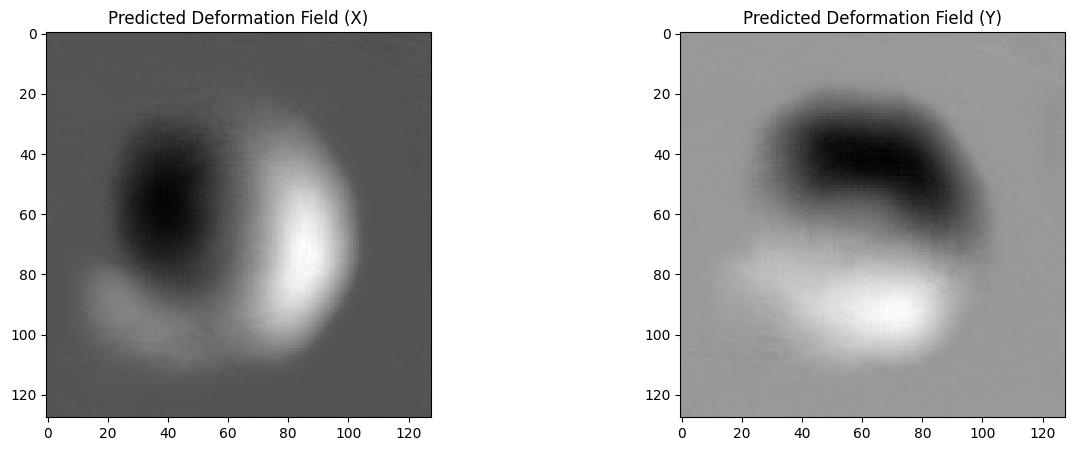

In [ ]:
# Create a figure with 1 row and 2 columns of subplots, setting the figure size to 15x5 inches
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Display the first channel of the predicted deformation field (X-direction) in the first subplot
ax[0].imshow(predicted[0, :, :, 0], cmap='gray')  # Use grayscale colormap for visualization
ax[0].set_title('Predicted Deformation Field (X)')  # Set the title for the first subplot

# Display the second channel of the predicted deformation field (Y-direction) in the second subplot
ax[1].imshow(predicted[0, :, :, 1], cmap='gray')  # Use grayscale colormap for visualization
ax[1].set_title('Predicted Deformation Field (Y)')  # Set the title for the second subplot

# Show the plots
plt.show()
